# Temperature-Salinity diagram using MOM6 output

This notebook shows how to plot a temperature-salinity diagram which is weighted by volume using xhistogram. 

The notebook is written using output from MOM6. If you want to use output from MOM5 the relevant diagnostics are as follows;
- Temperature: `temp` (in MOM6 this is `thetao`)
- Salinity: `salt`    (in MOM6 this is `so`)
- Cell area: `area_t`  (in MOM6 this is `areacello`)

Note that the coordinate (lat and lon) names also differ between MOM6 and MOM5. In MOM6, the tracer longitude coordinate is labelled `xh`, the tracer latitude coordinate is labelled `yh`, and the tracer vertical coordinate is `z_l`. In MOM5, the tracer longitude coordinate is labelled `xt_ocean`, the tracer latitude coordinate is labelled `yt_ocean`, and the tracer vertical coordinate is `st_ocean`. 

**Requirements**: The conda/analysis3 (or later) module on ARE. A session with 4 cores is sufficient for this example but more cores will be needed for larger datasets. 

Firstly, we load all required modules and start a client.

In [1]:
# analysis libraries
import pandas as pd
import xarray as xr
import numpy as np
import gsw
from xhistogram.xarray import histogram as xhistogram

# intake and Dask
import intake
catalog = intake.cat.access_nri
from dask.distributed import Client


# # warnings
# import warnings
# warnings.simplefilter('ignore')

# plotting libaries
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as colors

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45541,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38613,Total threads: 1
Dashboard: /proxy/46117/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44249,


## Load data

Select the region and coordinates of meridional section for the temperature-salinity diagram.

In [3]:
longitude = -25  # longitude of meridional section
latitude_range = slice(-90, -37)  # latitude range of section

Next, choose an experiment of any resolution. Here, only 1 year of the MOM6 `panant-01-zstar-v13` experiment is selected; if you want to use a longer time period, you might need more resources!

In [4]:
experiment = "panant-01-zstar-v13"
start_time = "1991-01-01"
end_time = "1991-12-31"

We define a function below to load output (temperature or salinity) on which we will compute the histogram for the T-S diagram.

In [5]:
def load_data(variable, frequency='fx'):
    
    '''
    variable: string defining the variable to load (e.g. `thetao` or `so`)
    '''

    catalog_subset = catalog[experiment]
    variable_search = catalog_subset.search(variable=variable, frequency=frequency)
    darray = variable_search.to_dask(xarray_open_kwargs={"decode_timedelta": False})

    darray = darray.get(variable)
    
    if 'time' in darray.coords:
        darray = darray.sel(time=slice(start_time, end_time))
    
    return darray
    

Now load the data using this function. 

In [6]:
salt = load_data('so', frequency='1mon')
temperature = load_data('thetao', frequency='1mon')
cell_area = load_data('areacello')

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

We now define a function to select out the region of interest. 

In [7]:
def select_region(darray):

    '''
    Subset the data array to the defined region. 
    '''

    darray_subset = darray.sel(xh=longitude, method='nearest').sel(yh=latitude_range)

    return darray_subset

And we subset the previously loaded data using this function. 

In [8]:
salt = select_region(salt)
temperature = select_region(temperature)
cell_area = select_region(cell_area)

Define a function to convert from potential temperature to conservative temperature and from practical salinity to absolute salinity. If adapting this to MOM5 output, make sure you check the temperature and salinity definitions/units - they may be different than for MOM6! To learn more about the different types of salinity and temperature measurements, and how to convert between them, visit the `GSW` toolbox: https://teos-10.github.io/GSW-Python/intro.html

In [9]:
def convert_units(t_array, s_array):

    '''
    T_array: Array containing model potential temperature in degrees celsius
    S_array: Array containing model practical salinity in psu 
    Vertical coordinate: In MOM6 the vertical coordiante 
    '''

    pressure = gsw.p_from_z(-s_array.z_l, s_array.yh)

    # This converts pratical salinity (psu) to absolute salinity (g/kg)
    SA_array = gsw.SA_from_SP(s_array, pressure, s_array.xh, s_array.yh)
    SA_array.attrs = {'units': 'Absolute Salinity (g/kg)'}

    # This converts potential temperature (deg C) to conservative temperature (deg C)
    CT_array = gsw.CT_from_pt(s_array, t_array)
    CT_array = CT_array.rename('thetao')
    CT_array.attrs = {'units': 'Conservative temperature (°C)'}
    

    return CT_array, SA_array

Convert the temperature and salinity data using this function and load it into memory. 

In [10]:
CT, SA = convert_units(temperature, salt)
CT = CT.compute()
SA = SA.compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 17.40 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Now define the function that computes the temperature and salinity bins for the T-S histogram. 

In [11]:
def compute_TS_bins(salt, temperature, area):
    
    temp_bins = np.arange(np.floor(temperature.min().values)-0.5, np.ceil(temperature.max().values)+0.6, 0.5)
    salt_bins = np.arange(np.floor(salt.min().values)-0.1, np.ceil(salt.max().values)+0.11, 0.1)
    
    # To create density contours in the T-S diagram
    temp_bins_mesh, salt_bins_mesh = np.meshgrid(temp_bins, salt_bins)
    TS_density = gsw.density.sigma2(salt_bins_mesh, temp_bins_mesh)
    
    # Calculate the volume of grid cells to account for varying grid cell thicknesses, 
    # especially in the vertical dimension
    volume = (temperature.z_l * area)

    # Create the 2D histogram array containing the temperature and salinity values, 
    # weighted by grid cell volume
    TS_histogram = xhistogram(temperature, salt, bins=(temp_bins, salt_bins), weights=volume)
    TS_histogram = TS_histogram.where(TS_histogram != 0).compute()
    
    return TS_histogram, TS_density, salt_bins_mesh, temp_bins_mesh 

Calculate the histogram. 

In [12]:
%%time
TS_histogram, TS_density, salt_bins_mesh, temp_bins_mesh = compute_TS_bins(SA, CT, cell_area)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 11.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 339 ms, sys: 57.9 ms, total: 397 ms
Wall time: 453 ms


Now we can plot this T-S histogram!

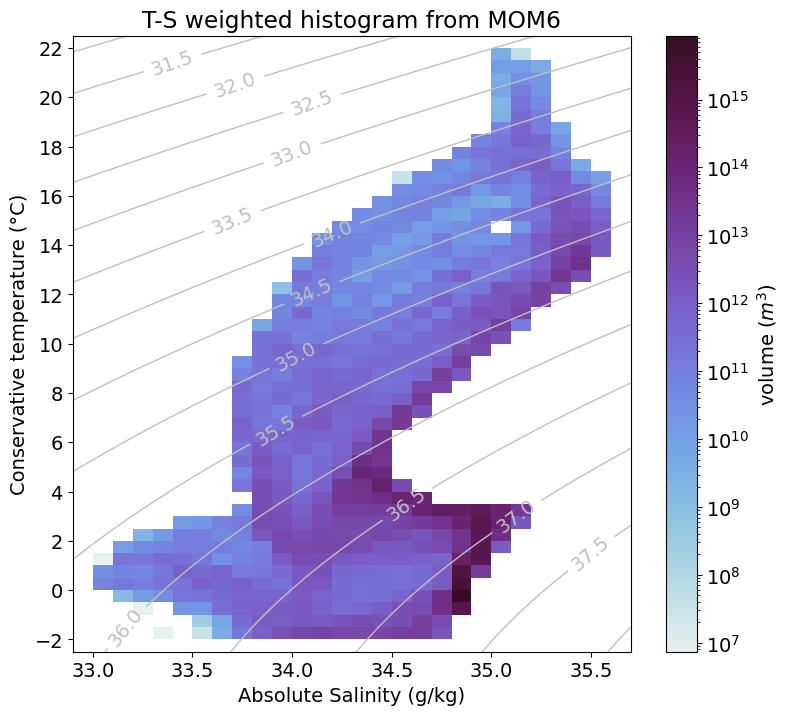

In [13]:
plt.rcParams['font.size']=14
plt.figure(figsize=(9, 8))

# normalize the colorbar to the min and maximum values of the histogram 
# using a LogNormal scale
norm=colors.LogNorm(vmin=TS_histogram.min().values, vmax=TS_histogram.max().values)

# Plot (shade) the TS histogram data
TS_histogram.plot(cmap=cmo.dense, norm=norm, cbar_kwargs=dict(label='volume ($m^{3}$)'))

# Add the density contours
cs = plt.contour(salt_bins_mesh, temp_bins_mesh, TS_density, 
                 colors='silver', linewidths=1, 
                 levels=np.arange(np.floor(TS_density.min()), np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)

plt.xlabel(SA.units)
plt.ylabel(CT.units)
plt.title("T-S weighted histogram from MOM6");

plt.xlim([32.9, 35.7])
plt.yticks(np.arange(-2, 23, 2))

plt.show()